This file tends to visualize the number and the potential impacts of fires around the city, while creating an estimator for the impact of the fire on the city in order to put into time-series model to make prediction of future years.

We include not only wildfires but also fires of other types since those will have smoke impact on the city as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

*While we obtained some data from EPA, since the monitors are still far from the city, we only take one dataset, i.e. gaseous monitors at county 35013, to have a general context about the impacts of fires to the city*

*In this case, we average the AQI on each date and plot first*

In [2]:
df_35013_gas = pd.read_json('../site35013_par.json')['monitors']
df_35013_gas = pd.json_normalize(df_35013_gas).T
df_35013_gas = df_35013_gas.reset_index().rename(columns={'index':'date', 0:'AQIs'})
df_35013_gas['date'] = pd.to_datetime(df_35013_gas['date'])
mean_avg = []
for i in range(df_35013_gas.shape[0]):
    mean_avg.append(np.mean(df_35013_gas.iloc[i]['AQIs']))
df_35013_gas['avg_AQIs'] = pd.Series(mean_avg)

From below, we could see that the daily data could be messy and unclear to serve our purpose

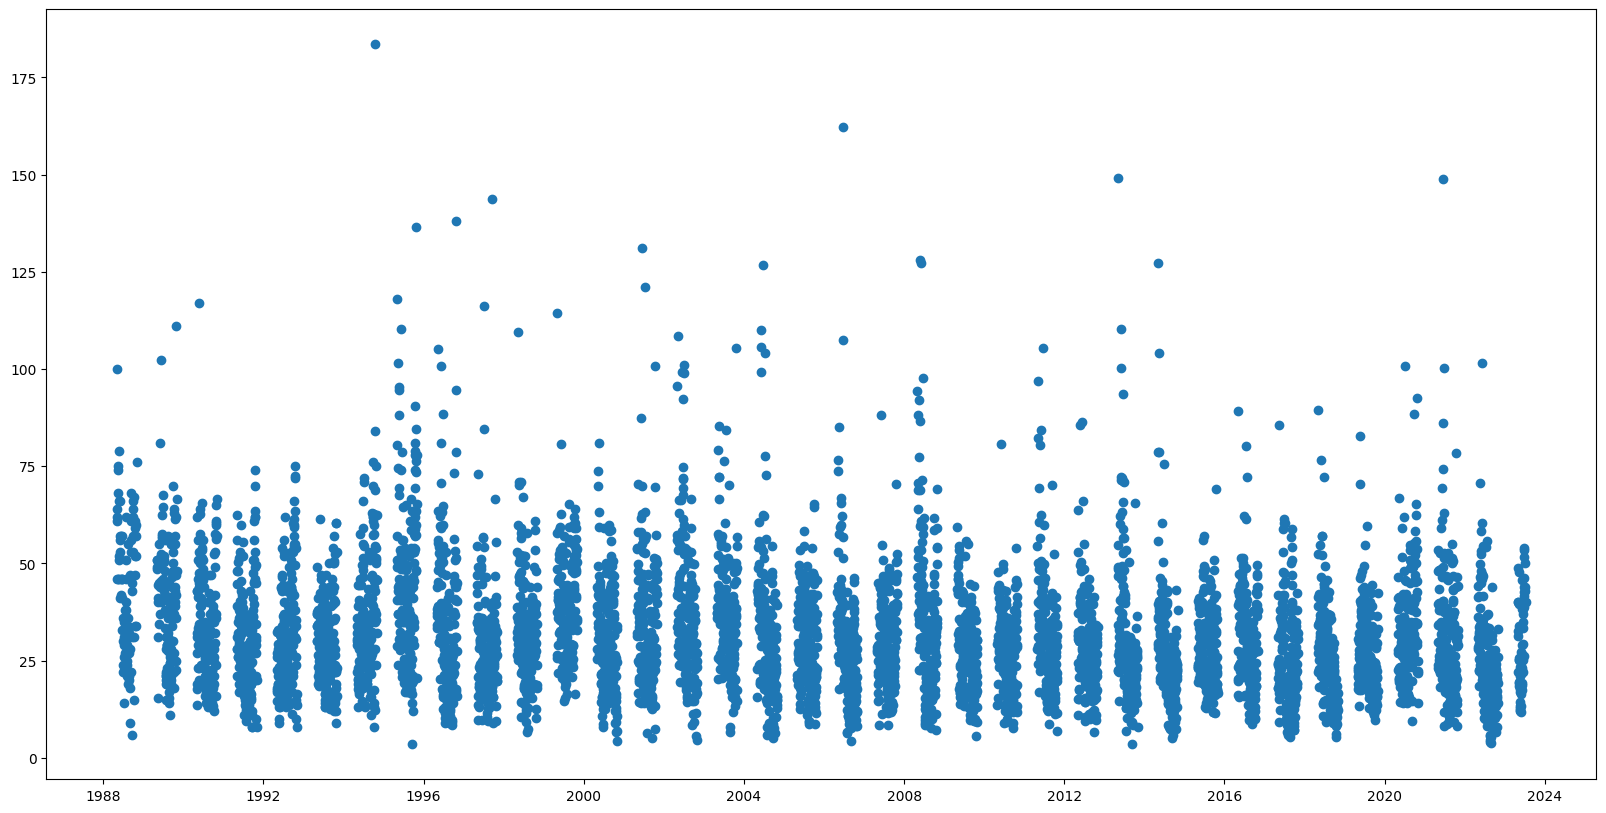

In [3]:
from matplotlib.pyplot import figure

figure(figsize=(20, 10), dpi=100)

plt.scatter(df_35013_gas['date'], df_35013_gas['avg_AQIs'])

In [24]:
df_35013_gas['ym'] = df_35013_gas['date'].dt.to_period('M')
df_35013_gas['ym'] = df_35013_gas['ym'].astype('str')
df_35013_gas['year'] = df_35013_gas['date'].dt.year
df_35013_gas['firstday'] = pd.to_datetime(df_35013_gas['ym'] + pd.Series(['-01']*df_35013_gas.shape[0]))


Trying to group the AQIs by year and month and aggregate using average to see if clearer trends would come up

In [5]:
ym = df_35013_gas.groupby(by='firstday').mean()['avg_AQIs'].reset_index()

(array([    0.,  3652.,  7305., 10957., 14610., 18262., 21915.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

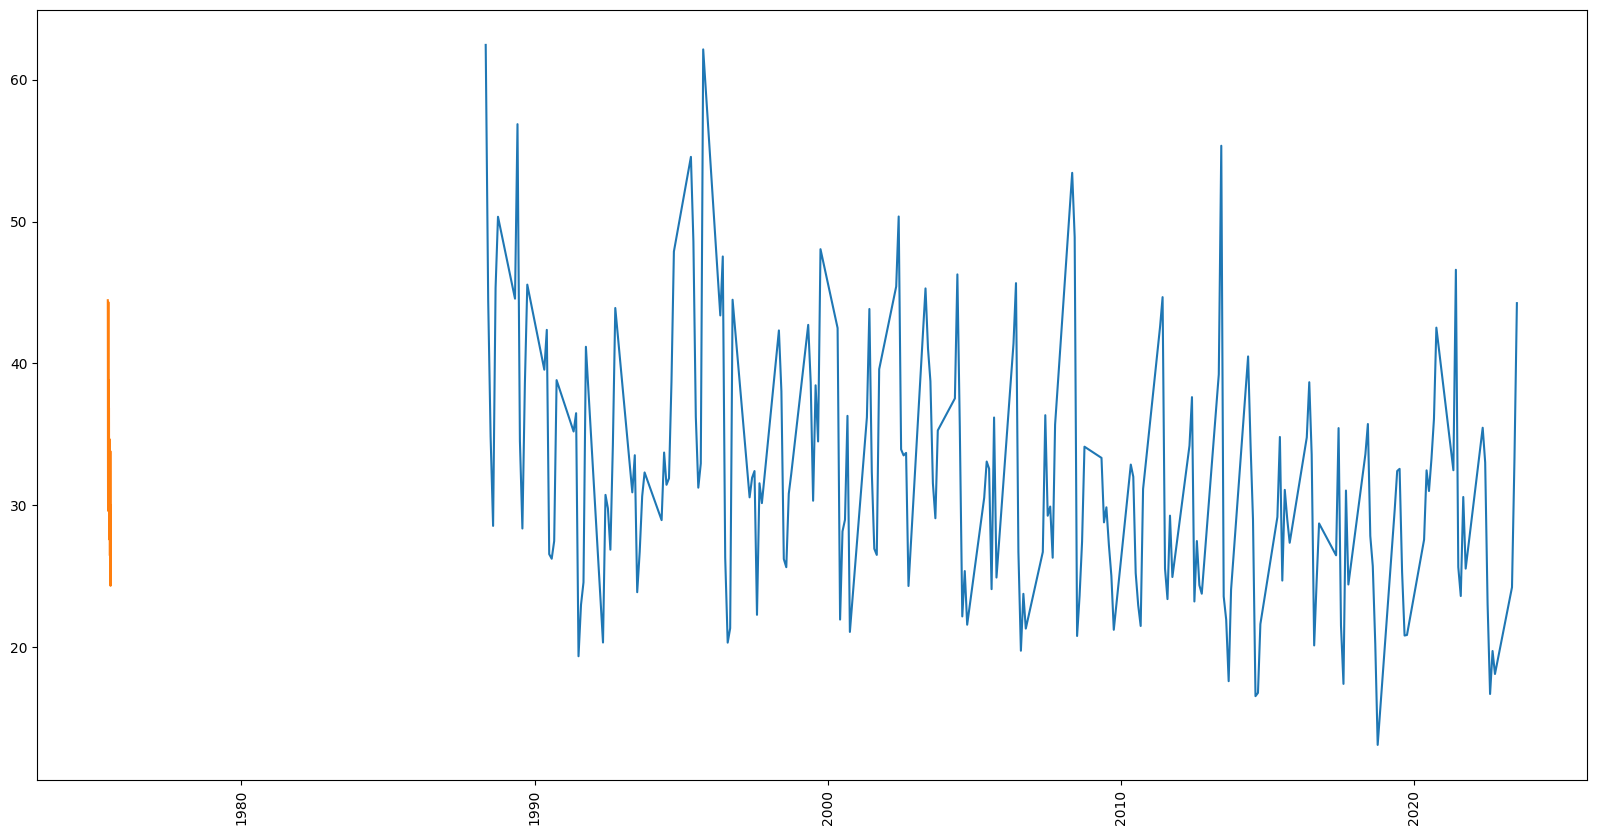

In [26]:
figure(figsize=(20, 10), dpi=100)
plt.plot(ym['firstday'], ym['avg_AQIs'])
plt.xticks(rotation='vertical')

In [7]:
df = pd.read_csv('../city.csv')
df.shape

c:\Users\wuron\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3460: DtypeWarning: Columns (0,1,2,3,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,27,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(194966, 34)

**Even though we extracted the wildfire data and filtered out dates outside of 1963-2023 and outside of 1250 miles range, the csv file was somehow having duplicating rows. But below we fixed that by removing duplicates and unexpected Fire_Year values**

*The dataset will be reproduced later to remove these steps. But due to time consideration, it will be fixed in this way for now.*

In [8]:
s = 'Prescribed fire data in this dataset represents only a fraction of the area burned in prescribed burns across all years due to lack of reporting, particularly on private lands. The missing prescribed burn data becomes more pronounced further back in time, particularly in the southeastern U.S.; however, errors and omissions still occur through the most recent years in this dataset. This dataset represents the most complete set of digitized polygon fire data available to the public that we, the authors, were able to collect. It is not a complete collection of all prescribed burns burned during the time period it represents.'
idx = df[df['Fire_Year']==s].index
df = df.drop(idx, axis=0)
df = df.reset_index(drop=True)

In [9]:
null_dist = df[df['Fire_Year'].isna()].index
df = df.drop(null_dist, axis=0)
df = df.reset_index(drop=True)

In [10]:
df = df.drop_duplicates(keep='first')
df.shape

(95064, 34)

In [11]:
df_subset = df.drop(columns=['rings'])

In order to build time-series model to predict for future years, as many as possible data will be needed for fitting the model. Therefore, instead of feeding in data that is grouped by years and aggregated using average, or randomly selecting a date among 5.1 to 10.31 for each Fire_Year, we tried to use the Listed Fire Dates to extract the start dates of each fire.

For most of them, the first date in Listed Fire Dates are the start date, or both start and the end if the fire is prescribed. Which raise another question that, would it be better to remove prescribed fires from the DataFrame since it is taken care of in a day. But due to time concern, this will be validated in the future.

In [12]:

df_subset['Listed_Fire_Start'] = pd.Series(df_subset['Listed_Fire_Dates'].str.split(':').str[1].str.split('|').str[0].str.split('(').str[0].str[:11])

df_subset['Listed_Fire_Start'] = pd.to_datetime(df_subset['Listed_Fire_Start'])
print(max(df_subset['Listed_Fire_Start']), min(df_subset['Listed_Fire_Start']))


2021-05-07 00:00:00 1899-12-30 00:00:00


Removed dates that are mistakenly recorded or simply do not have a set date.

In [13]:
wrong_start_date = df_subset[df_subset['Listed_Fire_Start']==min(df_subset['Listed_Fire_Start'])].index
df_subset = df_subset.drop(wrong_start_date).reset_index()
df_subset.shape

(92708, 35)

**We tried to create an estimator here considering the average distance from the fire to the city and the GIS Acres that it burned**

In [43]:
a = df_subset['avg_distance (miles)']
b = np.sqrt(df_subset['GIS_Acres'] * 640)
df_subset['pred'] = pd.Series(np.sqrt(2000 * b / a))

In [44]:
group_pred = df_subset.groupby(by='Listed_Fire_Start').mean()['pred'].reset_index()

X = group_pred.rename(columns={"Listed_Fire_Start":"ds", "pred":"y"})
X['ds'] = pd.to_datetime(X['ds'])

In [45]:
df_subset['Fire_Year'] = df_subset['Fire_Year'].astype('str')

### Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

**Below is the comparison between the two on the yearly basis. But in order to make better prediction, we will use daily data to build time-series model and at last obtained the future 25 years of prediction there.**

*The reason why we show 35013 gaseous data here is because it is the closest to the city and has clearer trends.*

Text(0.5, 1.0, 'Comparison between Estimated AQI and Avg Gaseous AQI from 35013')

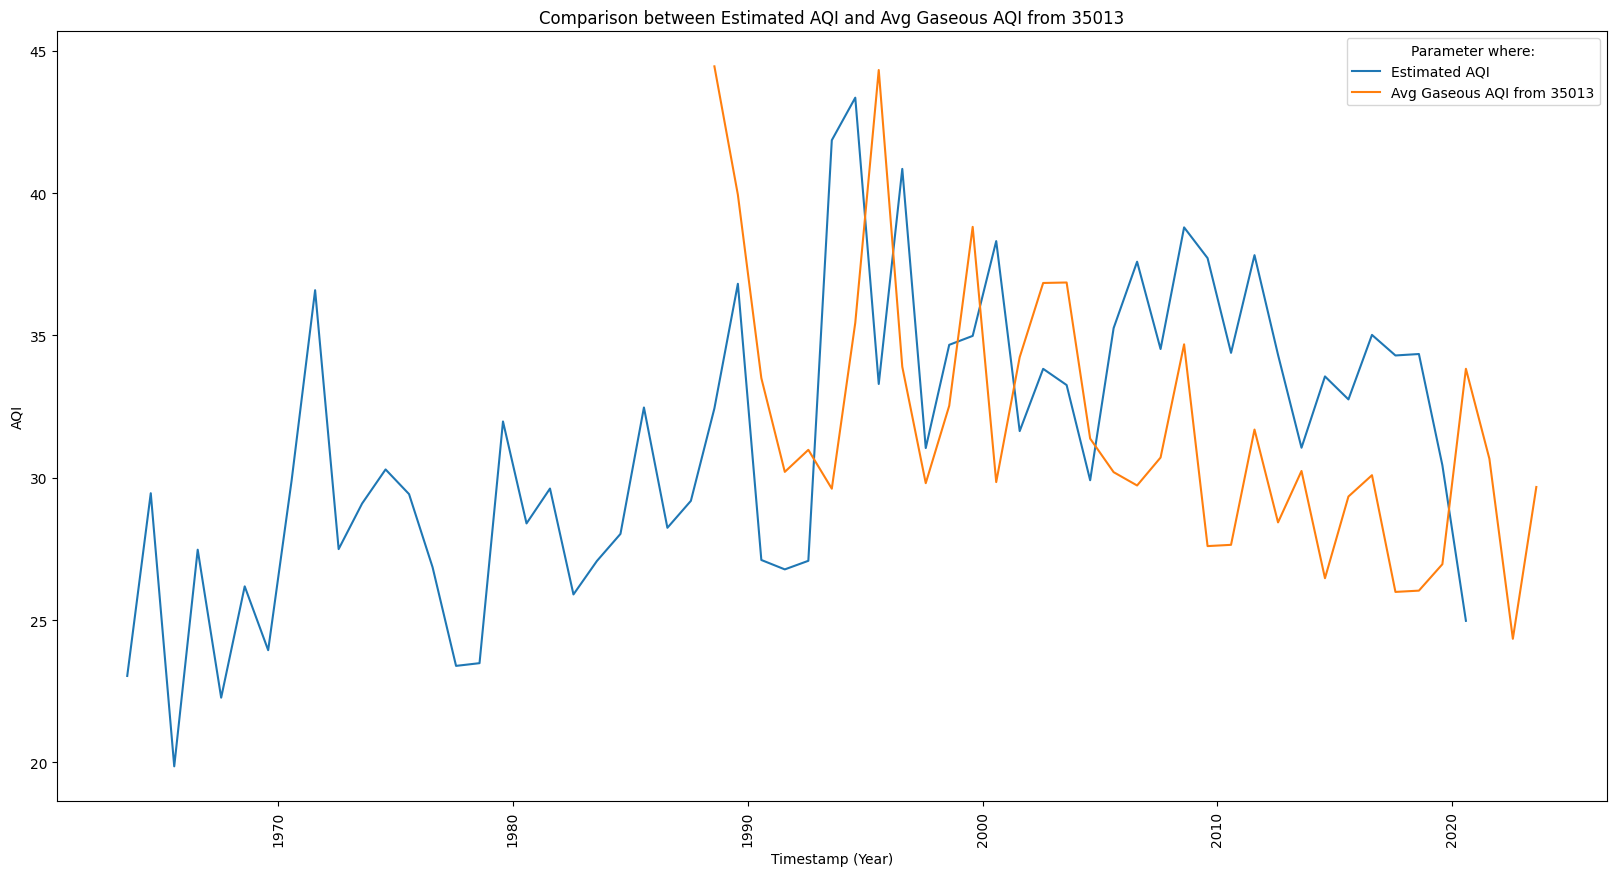

In [52]:
group_pred_year = df_subset.groupby(by='Fire_Year').mean()['pred'].reset_index()
group_pred_year['Fire_Year'] = pd.to_datetime(group_pred_year['Fire_Year'].astype('str') + pd.Series(['-08-01']*group_pred_year.shape[0]))

yr = df_35013_gas.groupby(by='year').mean()['avg_AQIs'].reset_index()
yr['year'] = pd.to_datetime(yr['year'].astype('str') + pd.Series(['-08-01']*yr.shape[0]))
figure(figsize=(20, 10), dpi=100)
plt.plot(group_pred_year['Fire_Year'], group_pred_year['pred'], label='Estimated AQI')
plt.plot(yr['year'], yr['avg_AQIs'], label='Avg Gaseous AQI from 35013')
plt.xticks(rotation='vertical')

plt.legend(title='Parameter where:')
plt.xlabel("Timestamp (Year)")
plt.ylabel("AQI")
plt.title('Comparison between Estimated AQI and Avg Gaseous AQI from 35013')

Since the AQI data we have are from 1988 to 2023, we are using wildfire data before 1988 as training dataset and the rest as test dataset to later compare to the AQI to see how good the estimator and the model are.

In [47]:
X_train = X[X.ds<='1988']
X_test = X[X.ds>='1988']

10:15:27 - cmdstanpy - INFO - Chain [1] start processing
10:15:28 - cmdstanpy - INFO - Chain [1] done processing


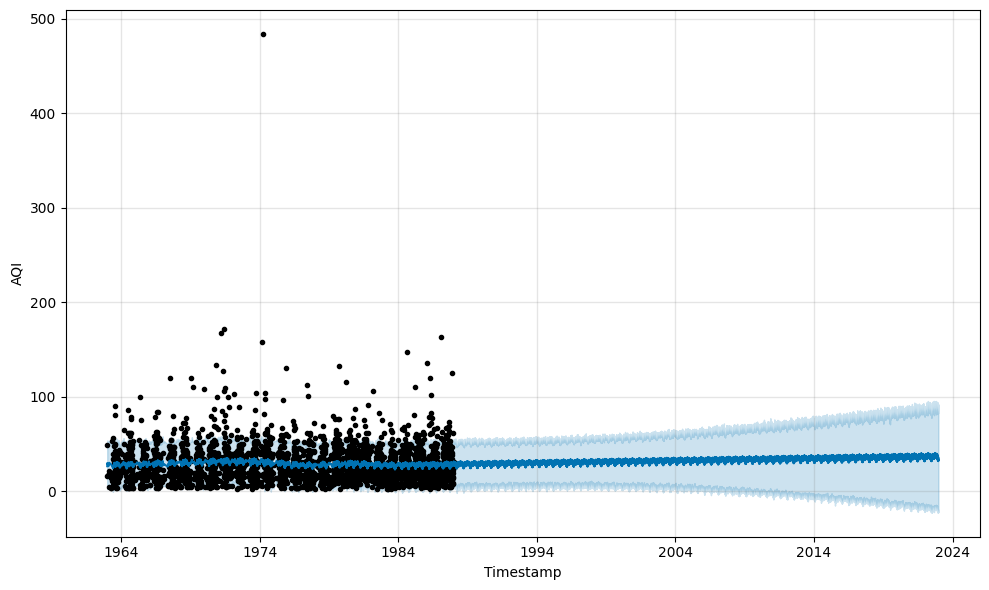

In [48]:
from prophet import Prophet

m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('yearly', period=181.25, fourier_order=3, mode='additive')
# m.add_regressor('regressor', mode='additive')
m.fit(X_train)

future = m.make_future_dataframe(periods=365*35)
fcst = m.predict(future)
fig = m.plot(fcst, xlabel='Timestamp', ylabel='AQI')

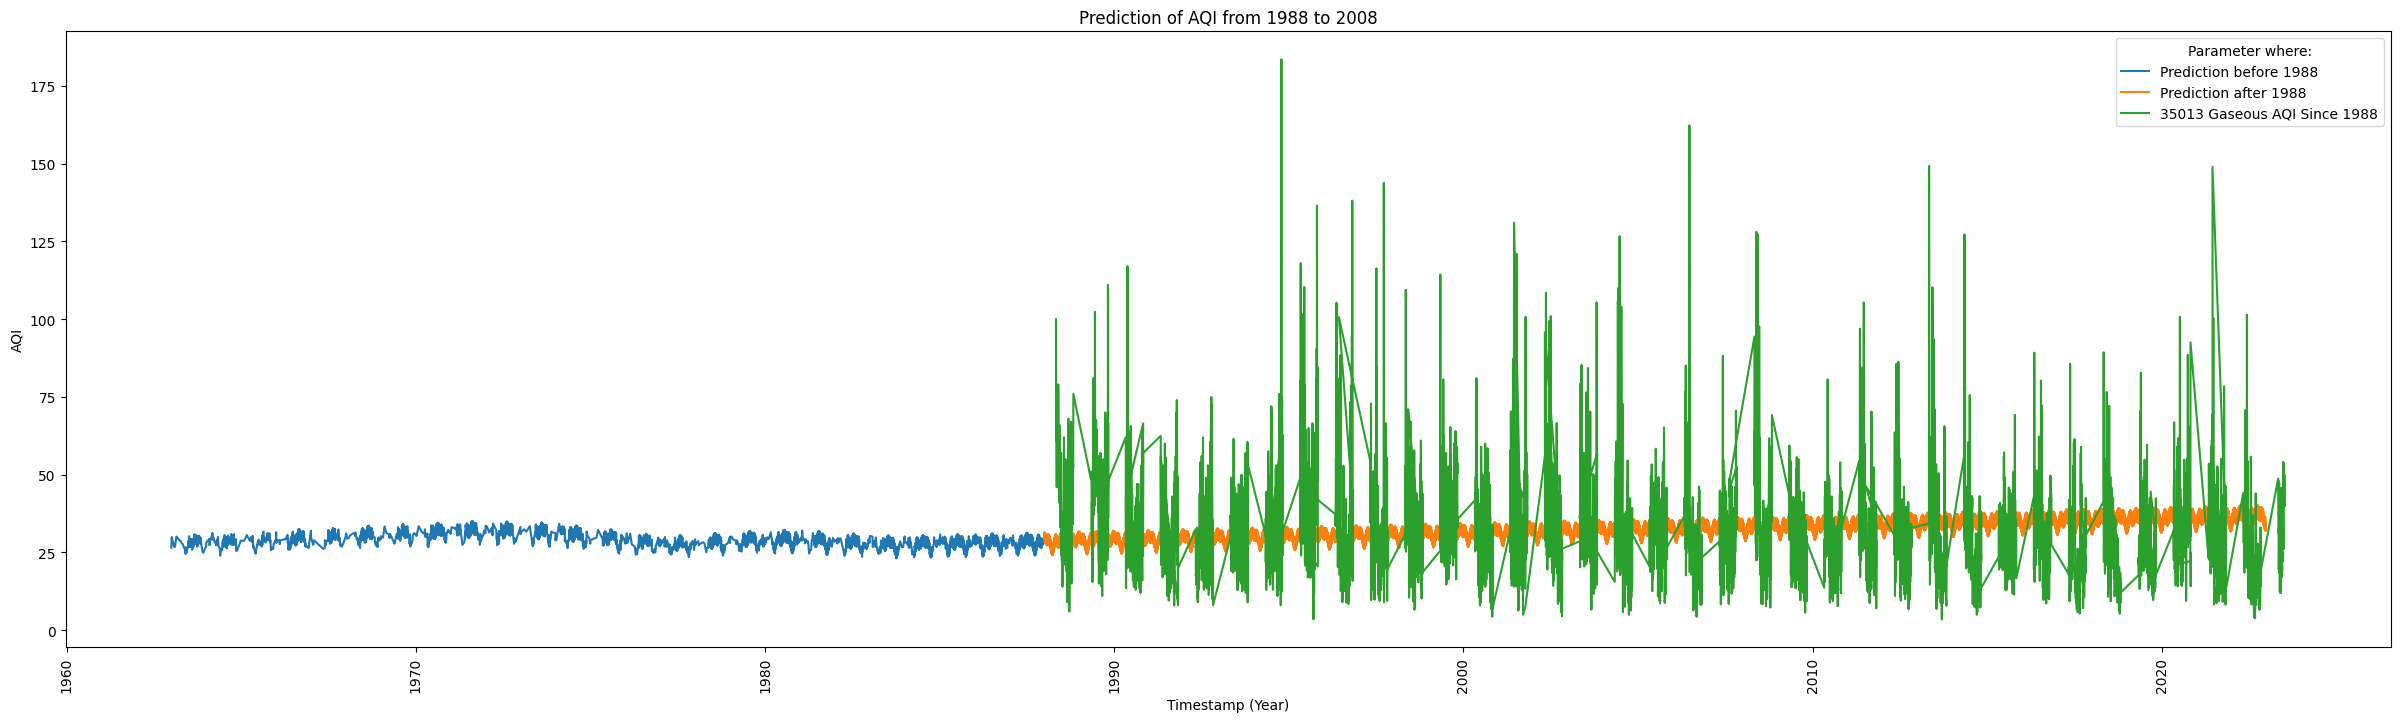

In [49]:
x_pre = fcst[fcst['ds']>='1988']['ds']
y_pre = fcst[fcst['ds']>='1988']['yhat']
x = fcst[fcst['ds']<'1988']['ds']
y = fcst[fcst['ds']<'1988']['yhat']
# plot
figure(figsize=(30, 8), dpi=100)
# fig, ax = plt.subplots()

# ax.bar(x, y, width=.8, edgecolor="white", linewidth=0.7)
plt.plot(x, y, label='Prediction before 1988')
plt.plot(x_pre, y_pre, label='Prediction after 1988')
plt.plot(df_35013_gas['date'], df_35013_gas['avg_AQIs'], label='35013 Gaseous AQI Since 1988')
# labels = list(range(2002,2024))

plt.xticks(rotation='vertical')
plt.legend(title='Parameter where:')
plt.xlabel("Timestamp (Year)")
plt.ylabel("AQI")
plt.title('Prediction of AQI from 1988 to 2008')

plt.show()


See that the trends are not too bad for the daily basis comparison between predicted and the gaseous data from 35013 site, we continue to predict for future years

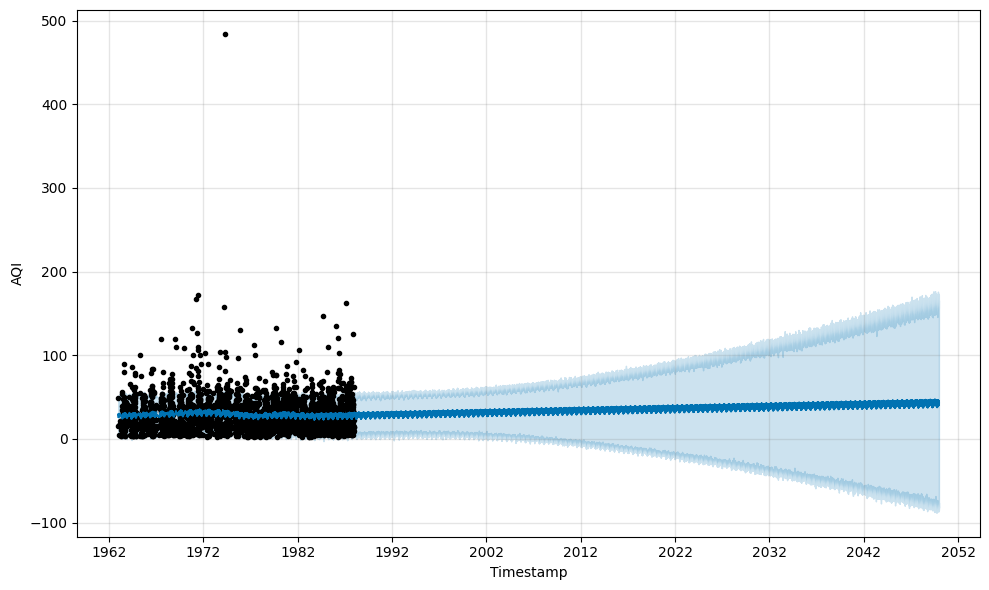

In [57]:
future2024 = m.make_future_dataframe(periods=365*62)
fcst = m.predict(future2024)
fig = m.plot(fcst, xlabel='Timestamp', ylabel='AQI')

C:\Users\wuron\AppData\Local\Temp\ipykernel_13560\959164237.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_pre = fcst[fcst['ds']>='1988'][fcst['ds']<='2023']['ds']
C:\Users\wuron\AppData\Local\Temp\ipykernel_13560\959164237.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_pre = fcst[fcst['ds']>='1988'][fcst['ds']<='2023']['yhat']


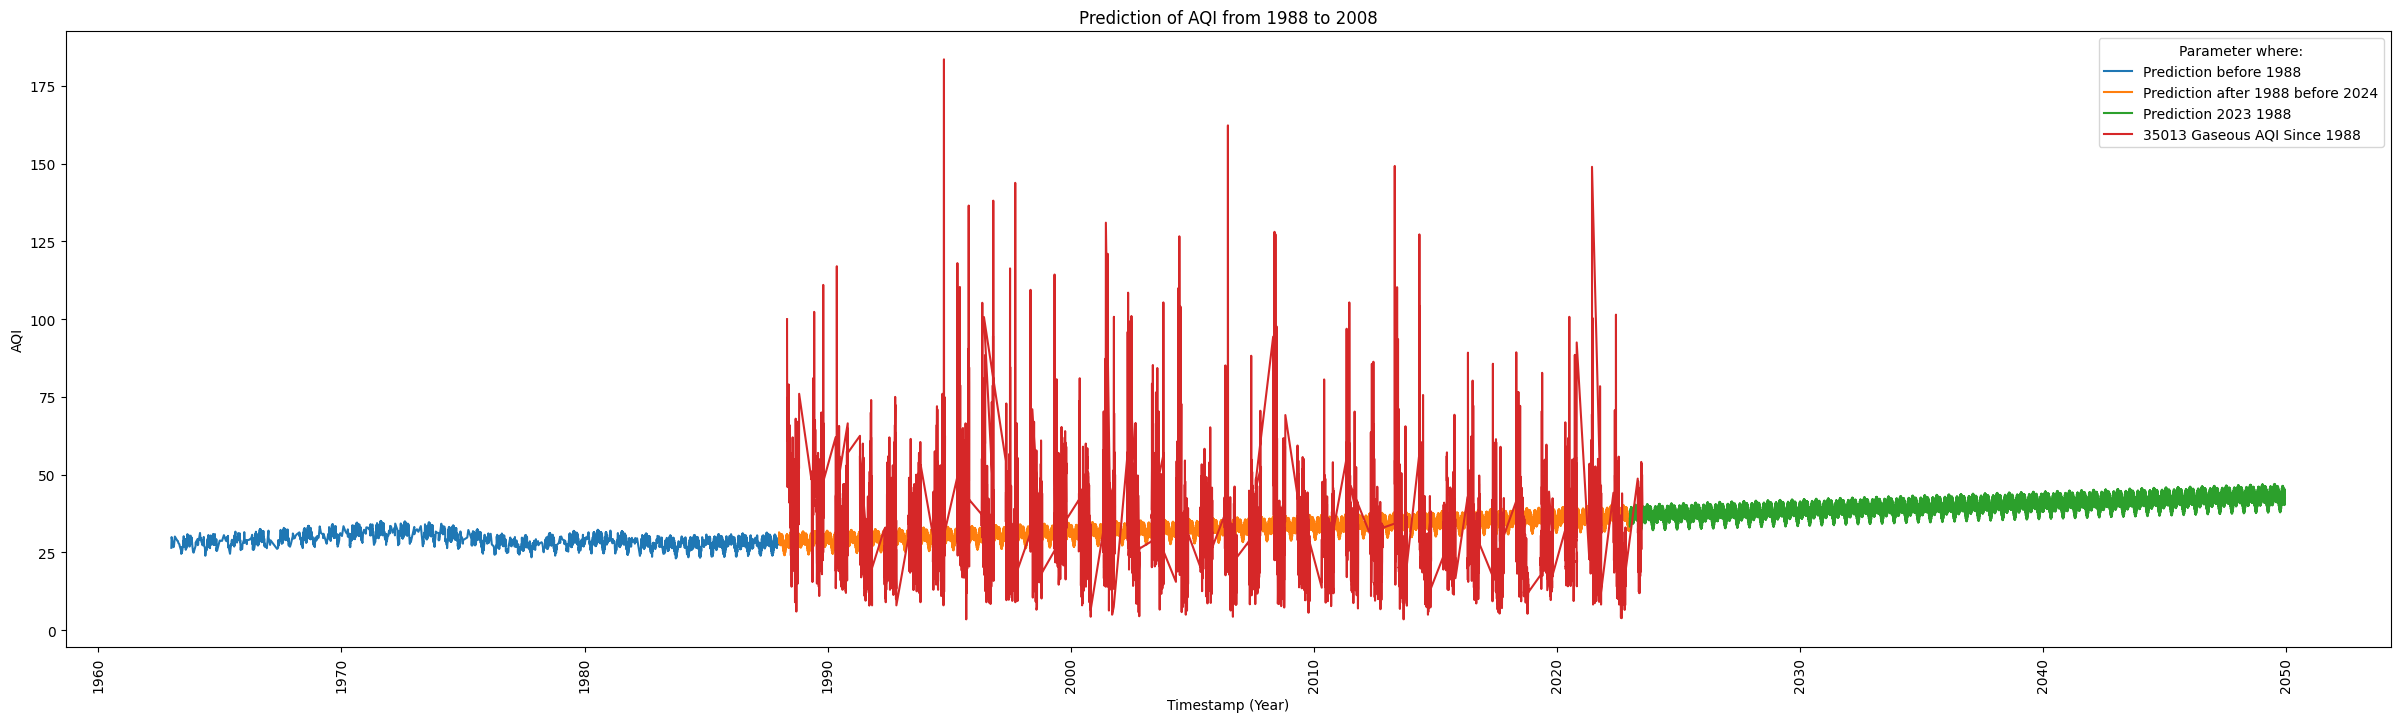

In [58]:
x_pre2024 = fcst[fcst['ds']>'2023']['ds']
y_pre2024 = fcst[fcst['ds']>'2023']['yhat']
x_pre = fcst[fcst['ds']>='1988'][fcst['ds']<='2023']['ds']
y_pre = fcst[fcst['ds']>='1988'][fcst['ds']<='2023']['yhat']
x = fcst[fcst['ds']<'1988']['ds']
y = fcst[fcst['ds']<'1988']['yhat']
# plot
figure(figsize=(30, 8), dpi=100)
# fig, ax = plt.subplots()

# ax.bar(x, y, width=.8, edgecolor="white", linewidth=0.7)
plt.plot(x, y, label='Prediction before 1988')
plt.plot(x_pre, y_pre, label='Prediction after 1988 before 2024')
plt.plot(x_pre2024, y_pre2024, label='Prediction 2023 1988')
plt.plot(df_35013_gas['date'], df_35013_gas['avg_AQIs'], label='35013 Gaseous AQI Since 1988')
# labels = list(range(2002,2024))

plt.xticks(rotation='vertical')
plt.legend(title='Parameter where:')
plt.xlabel("Timestamp (Year)")
plt.ylabel("AQI")
plt.title('Prediction of AQI from 1988 to 2008')

plt.show()


In [61]:
fcst[fcst['ds']>'2023']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
16446,2023-01-02,36.415079,-22.044258,87.588202,-14.815556,82.363380,-1.418112,-1.418112,-1.418112,0.024030,0.024030,0.024030,0.024030,0.024030,0.024030,-1.418112,-1.418112,-1.418112,35.872033
16447,2023-01-03,36.415726,-22.894562,83.642458,-14.823935,82.366926,-1.270632,-1.270632,-1.270632,-0.051122,-0.051122,-0.051122,-0.051122,-0.051122,-0.051122,-1.270632,-1.270632,-1.270632,33.283449
16448,2023-01-04,36.416373,-22.999247,86.231852,-14.832315,82.370472,-1.120860,-1.120860,-1.120860,-0.012933,-0.012933,-0.012933,-0.012933,-0.012933,-0.012933,-1.120860,-1.120860,-1.120860,34.824531
16449,2023-01-05,36.417021,-22.104368,87.774170,-14.840694,82.374017,-0.969964,-0.969964,-0.969964,-0.009574,-0.009574,-0.009574,-0.009574,-0.009574,-0.009574,-0.969964,-0.969964,-0.969964,35.098384
16450,2023-01-06,36.417668,-21.397808,83.700545,-14.849074,82.377563,-0.819112,-0.819112,-0.819112,-0.011339,-0.011339,-0.011339,-0.011339,-0.011339,-0.011339,-0.819112,-0.819112,-0.819112,35.185615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26287,2049-12-12,42.785496,-80.397616,157.878069,-75.722188,160.119329,-0.254337,-0.254337,-0.254337,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.005999,-0.254337,-0.254337,-0.254337,42.274500
26288,2049-12-13,42.786143,-85.006184,165.786724,-75.729136,160.124241,-0.207793,-0.207793,-0.207793,0.024030,0.024030,0.024030,0.024030,0.024030,0.024030,-0.207793,-0.207793,-0.207793,43.606516
26289,2049-12-14,42.786791,-75.875469,157.022163,-75.736085,160.129153,-0.154062,-0.154062,-0.154062,-0.051122,-0.051122,-0.051122,-0.051122,-0.051122,-0.051122,-0.154062,-0.154062,-0.154062,40.445382
26290,2049-12-15,42.787438,-82.215960,157.341096,-75.743033,160.134065,-0.093646,-0.093646,-0.093646,-0.012933,-0.012933,-0.012933,-0.012933,-0.012933,-0.012933,-0.093646,-0.093646,-0.093646,42.140410


In [ ]:
# x_35013_par = aqi_avg[aqi_avg['type']=='particle'][aqi_avg['site']==35013]['year']
# y_35013_par = aqi_avg[aqi_avg['type']=='particle'][aqi_avg['site']==35013]['aqi']
# plt.plot(x_35013_par, y_35013_par, label='particle monitor from 35013')

# x_35013_gas = aqi_avg[aqi_avg['type']=='gas'][aqi_avg['site']==35013]['year']
# y_35013_gas = aqi_avg[aqi_avg['type']=='gas'][aqi_avg['site']==35013]['aqi']
# plt.plot(x_35013_gas, y_35013_gas, label='gaseous monitor from 35013')

# x_48109_par = aqi_avg[aqi_avg['type']=='particle'][aqi_avg['site']==48109]['year']
# y_48109_par = aqi_avg[aqi_avg['type']=='particle'][aqi_avg['site']==48109]['aqi']
# plt.plot(x_48109_par, y_48109_par, label='particle monitor from 48109')

# # x_avg = (x_35013_par+x_35013_gas+x_48109_par) / 3

# x = X['ds']
# y = X['y']*50
# plt.plot(x, y, label='estimator')

# plt.xticks(rotation='vertical')
# plt.legend(title='Parameter where:')
# plt.xlabel("Timestamp (Year)")
# plt.ylabel("AQI")


### Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.

In [ ]:
fifty = df_subset['avg_distance (miles)'] // 50
fifty = [((i+1)*50) for i in fifty]
df_subset['within x-miles range'] = pd.Series(fifty)

In [ ]:
range_of_50 = df_subset.groupby(by=["within x-miles range"]).count()['OBJECTID']
range_of_50 = pd.DataFrame(range_of_50).reset_index().rename(columns={'OBJECTID':'Fire_Count'})

,within x-miles range,Fire_Count
0,50.0,235
1,100.0,675
2,150.0,910
3,200.0,1138
4,250.0,1449
5,300.0,1412
6,350.0,1663
7,400.0,1653
8,450.0,1289
9,500.0,1700


In [ ]:
x = range_of_50['within x-miles range']
y = range_of_50['Fire_Count']
y_cumu = y.cumsum()


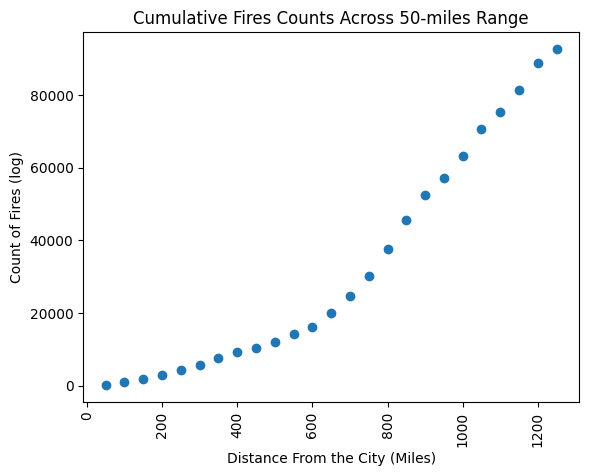

<Figure size 2000x600 with 0 Axes>

In [ ]:

fig, ax = plt.subplots()

ax.scatter(x, y_cumu)

plt.xticks(rotation='vertical')
plt.xlabel("Distance From the City (Miles)")
plt.ylabel("Count of Fires (log)")
plt.title('Cumulative Fires Counts Across 50-miles Range')
plt.figure(figsize=(20,6))
plt.show()

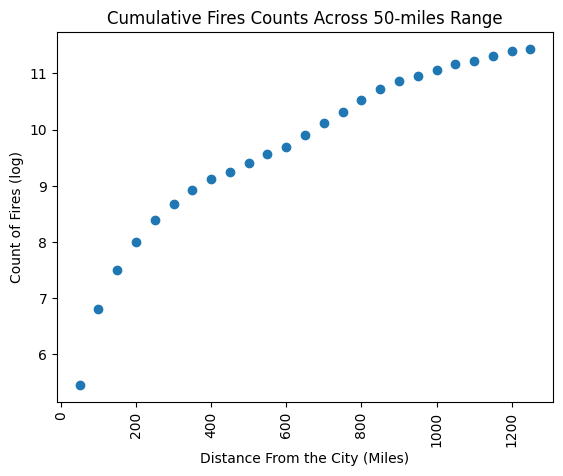

<Figure size 2000x600 with 0 Axes>

In [ ]:

fig, ax = plt.subplots()

ax.scatter(x, np.log(y_cumu))

plt.xticks(rotation='vertical')
plt.xlabel("Distance From the City (Miles)")
plt.ylabel("Count of Fires (log)")
plt.title('Cumulative Fires Counts Across 50-miles Range')
plt.figure(figsize=(20,6))
plt.show()

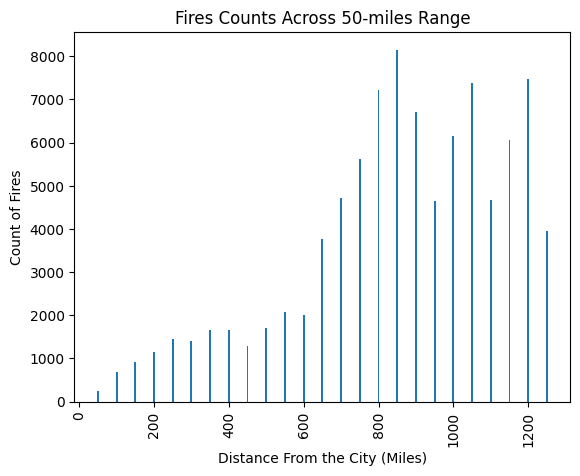

<Figure size 2000x600 with 0 Axes>

In [ ]:

fig, ax = plt.subplots()

ax.bar(x, y, width=5, linewidth=10)


plt.xticks(rotation='vertical')
plt.xlabel("Distance From the City (Miles)")
plt.ylabel("Count of Fires")
plt.title('Fires Counts Across 50-miles Range')
plt.figure(figsize=(20,6))
plt.show()

### Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

In [ ]:
df_subset["Fire_Year"] = df_subset["Fire_Year"].astype('str')
acres_per_yr = df_subset.groupby(by=['Fire_Year'])['GIS_Acres'].sum()

In [ ]:
acres_per_yr = pd.DataFrame(acres_per_yr).reset_index().rename(columns={'GIS_Acres':'Total_GIS_Acres'})

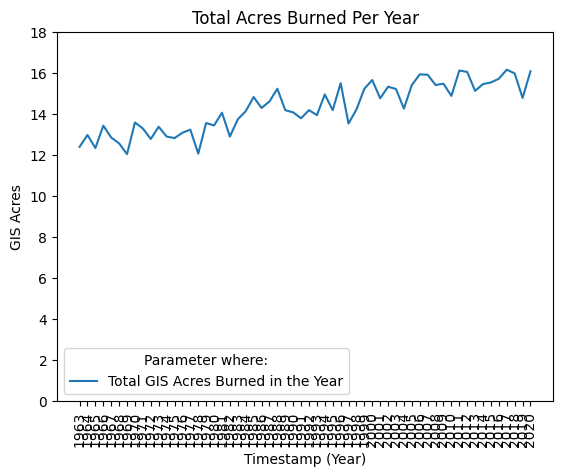

<Figure size 4000x1600 with 0 Axes>

In [ ]:
x = acres_per_yr['Fire_Year']
y = np.log(acres_per_yr['Total_GIS_Acres'])
# plot
fig, ax = plt.subplots()

# ax.bar(x, y, width=.8, edgecolor="white", linewidth=0.7)
ax.plot(x, y, label='Total GIS Acres Burned in the Year')
ax.set_ylim(0,18)

# labels = list(range(2002,2024))

plt.xticks(rotation='vertical')
plt.legend(title='Parameter where:')
plt.xlabel("Timestamp (Year)")
plt.ylabel("GIS Acres")
plt.title('Total Acres Burned Per Year')

plt.figure(figsize=(40,16))
plt.show()
# acres_per_yr